In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage import io
from skimage.restoration import denoise_bilateral
from scipy.io import loadmat


def show_image(image, title='', is_fourier=False):
    """Show image with matplotlib"""
    plt.figure()
    plt.title(title)
    if is_fourier:
        plt.imshow(np.abs(image), cmap='gray', vmax=np.abs(image).max()*0.002)
    else:
        plt.imshow(np.abs(image), cmap='gray')
    plt.axis('off')
    plt.show()

# A bit of context
MRI stands for Magnetic Resonance Imaging.
It is a medical imaging modality that is used to probe soft tissues inside the human body non-invasively and without the use of ionizing radiations.

The MRI data is acquired in the Fourier space of the image. Tradiailly, this acquisition domain is also called "k"-space, with "k" referring to spatial frequency.
However, MRI is particularly slow because it relies on the Magnetic Resonance phenomenon, which is inherently slow.
One way to speed up MRI is to acquire fewer signals (k-space shots ${\bf y}$), i.e. undersample.
If we do that, we find ourselves in a situation where we have not enough signals to reconstruct the image using simply the Inverse Fourier Transform ($F^{-1}$) as is typically done.
In fact, we have an ill-posed inverse problem that one must solve using priors on the MR images ${\bf x}$.

$$
F_{\Omega}{\bf x} = {\bf y}
$$

where $F_{\Omega}$ is a masked Fourier Transform with a mask $\Omega$ that selects the sample locations in the k-space.

This means that we need a function to tell apart all the possible solutions of the inverse problem, that tells which solution is more likely to be an MR image.

In classical Compressed Sensing, these priors are handcrafted.
Deep Learning allows us to learn these priors from data.

In this exercise, we will load a basic synthetic MR image, understand the corresponding Fourier space (acquisition domain) and later undersample the signal. Finally, we reconstruct the image and denoise it.

### Load an Synthetic MRI image for our use
Here we simply pull up an already saved synthetic brain MR image we have saved in the repository.

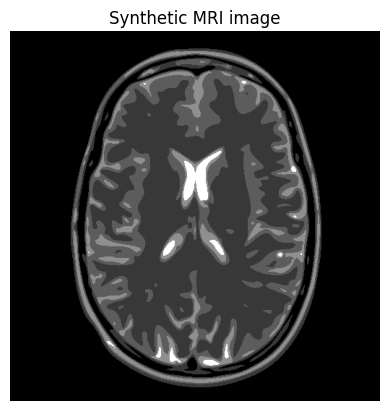

In [2]:
dirimg = os.path.join(os.getcwd(), "data")
img_size = 512  
FOV = 0.2 
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = os.path.join(dirimg, filename)
mri_img = io.imread(mri_filename, as_gray=True)
show_image(mri_img, "Synthetic MRI image")

### MRI Acquisition
Traditional MR acquisition takes place in the fourier domain of the image. 
In the most simplistic example, to acquire the above image, we sample its corresponding Fourier coefficients.
Then the image is reconstructed by transforming this acquired coeffcients back to image domain.
Note that the Fourier Coefficients is in complex domain.


Below we write simple interfaces to transfer the image to fourier coefficients and back to image domain.

In [3]:
def image_to_coeff(image):
    """Convert image to Fourier coefficients"""
    return np.fft.fftshift(np.fft.fft2(image))

def coeff_to_image(coeff):
    """Convert Fourier coefficients to image"""
    return np.fft.ifft2(np.fft.ifftshift(coeff))

#### Visualize the Fourier coefficients
**TODO:** Can you please write the code to visualize the Fourier coefficients of the image? Try to use above defined functions and `show_image`.


**PROTIP:** Maybe pass `is_fourier=True` to better visualize.

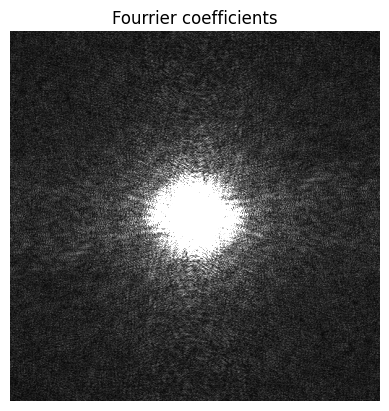

In [4]:
#<TODO: compute the Fourier coefficients of the image and display the result>
coeff_img = image_to_coeff(mri_img)
show_image(coeff_img,'Fourrier coefficients', is_fourier = True)

### Undersampling the acquistion
Now as the MRI scans are very slow, we traditionally undersample the image. 

**TODO:** Based on the above coefficients, what portions of the coefficients are most important? 

**Answer**: As it is known from the above coefficients, the center area is more important. This part also represents the low frequency part in k-space.

#### Undersampling mask
Here we pull up an already generated mask. The mask is a binary image with 1s where we want to sample and 0s where we don't want to sample. We will use this mask to sample the Fourier coefficients of the image.

**TODO**: Can you please get the fourier coefficients and sample is based on the mask?

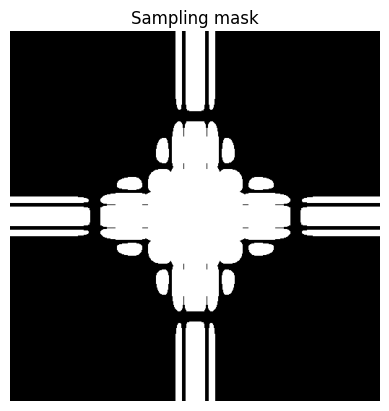

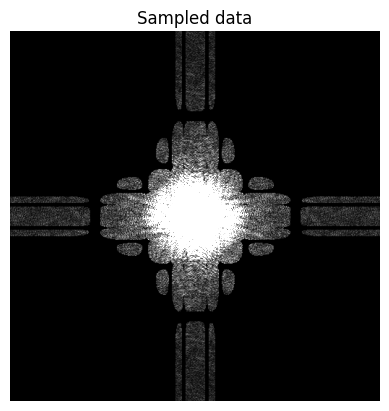

In [5]:
densities = loadmat(os.path.join(dirimg, "2d_sampling_densities.mat"))['distrib2d_N512_sym10']
fourier_mask = densities > 15 * densities.min() 

show_image(fourier_mask, 'Sampling mask')


# 1. Apply the mask to the Fourier coefficients of the image
# 2. Visualize the sampled data
sampled_coeff = coeff_img * fourier_mask #<TODO: apply mask to Fourier coefficients>
show_image(sampled_coeff,'Sampled data', is_fourier=True)

### Modeling noise
Generally, the acquired data at the scanner has noise in it. This noise is usually additive white gaussian noise. 

**TODO**: Can you please add this noise into the sampled data above. Use `np.random.random()` to generate random gaussian noise. Be careful, add noise only on sampled fourier coefficients, others must remain 0.

In [6]:
noisy_data = sampled_coeff + np.random.random(sampled_coeff.shape)#<TODO: Your code here>

### Reconstruct the image
**TODO**: Can you please take the noisy samples back to image domain using `coeff_to_image` and visualize the result?

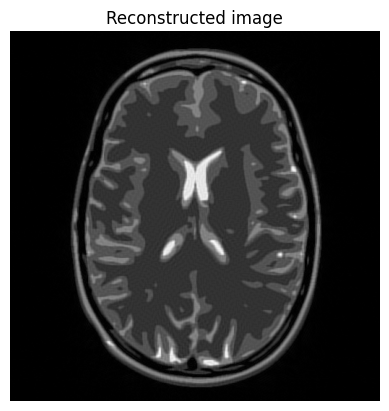

In [7]:
reconstructed_image = coeff_to_image(noisy_data) #<TODO: Your code here>
show_image(reconstructed_image, 'Reconstructed image')

### Denoising the final reconstructed image.

The reconstructed image above is noisy due to 1) sample noise we simulated, and also as we 2) undersampled the acquisition.

**TODO**: Now we would like to clean this image, can you use Bilateral filter from `scikit-image` library to denoise the image?
Have a look at the documentation of `denoise_bilatral`.

**NOTE**: Bilateral filters work on real images, while reconstructed image is complex, maybe pull up only the magnitude image. 

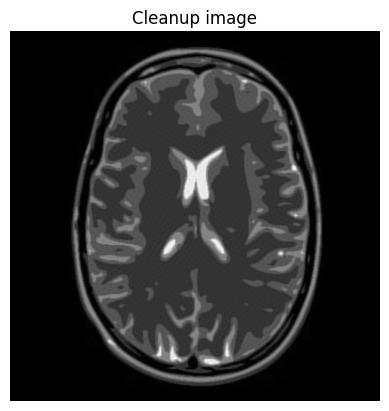

In [8]:
cleanup_image = denoise_bilateral(np.abs(reconstructed_image), sigma_color=None, sigma_spatial=0.5)#<TODO: Add code to renoise the image>
show_image(cleanup_image, 'Cleanup image')